# Generating Handwriting from model

### Abstract

In this notebook we will use the LSTM model generated by training the model in the train_model.py program and transform a text into a handwriting. We will use the translations that we created while data preprocessing for converting the text to one hot encoding and then feeding it to the model.

#### Importing libraries 

In [1]:
import os
import pickle
import argparse
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.mlab as mlab
from matplotlib import animation
import seaborn
from matplotlib.pyplot import figure
from collections import namedtuple

#### Generating Co-ordinates

Here we take in the output from the model which contain the following components:
* e - end of stroke probablity which is of the type bunomial distribution
* mu1, m2 - mean of the Gaussian distribution for the co-ordinates 
* std1, std2 - standard distribution of the Gaussian distribution for the co-ordinates 
* rho - the co-relation between the two co-ordinates

We are taking random samples from these distribution. For pen point lifted or not we take sample from a binomial distribution defined by "e" and for co-ordinates we take random sample from multivariate distribution.

In [2]:
def get_coordinates(e, mu1, mu2, std1, std2, rho):
    cov = np.array([[std1 * std1, std1 * std2 * rho],
                    [std1 * std2 * rho, std2 * std2]])
    mean = np.array([mu1, mu2])

    x, y = np.random.multivariate_normal(mean, cov)
    end = np.random.binomial(1, e)
    return np.array([x, y, end])

#### Identifying Individual strokes

Here we split the co-ordinates by iterating through the co-ordinates and identifying the end of stroke (which is indicated by a 1) and then taking all the co-ordinates till that point into one array which becomes one stroke and we repeat this till all the points are iterated.

In [3]:
def split_strokes(points):
    points = np.array(points)
    strokes = []
    b = 0
    for e in range(len(points)):
        if points[e, 2] == 1.:
            strokes += [points[b: e + 1, :2].copy()]
            b = e + 1
    return strokes

#### Get Handwriting Distributions and co-ordinates 

Here we feed in the text and the label translations to transform the assci text to handwritten text.
1. We first perform a one hot encoding on the input text
2. Pass the encoded data to the model in a Tensorflow session which returns distribution data regarding the handwritting 
3. get the co-ordinates from the distributions 

Here the bias is used to allow the model to generate a fine set of co-ordinates. 
The actual data does not contain fine strokes and so adding a bias allows us to create a fine quality of strokes. 

In [4]:
def get_handwriting(sess, text, translation, bias = 1.0):
    
    fields = ['coordinates', 'sequence', 'bias', 'e', 
              'pi', 'mu1', 'mu2', 'std1', 'std2', 'rho', 
              'window', 'kappa', 'phi', 'finish', 'zero_states']
    
    vs = namedtuple('Params', fields)(*[tf.get_collection(name)[0] for name in fields])

    # One hot encoding 
    text = np.array([translation.get(c, 0) for c in text])
    coord = np.array([0., 0., 1.])
    coordinates = [coord]
    sequence = np.eye(len(translation), dtype=np.float32)[text]
    sequence = np.expand_dims(np.concatenate([sequence, np.zeros((1, len(translation)))]), axis=0)

    _phi, _window, _kappa, strokes = [], [], [], []
    sess.run(vs.zero_states)
    sequence_len = len(text)
    
    for s in range(1, 60 * sequence_len + 1):
        print('\r[{:5d}] sampling'.format(s), end='')

        e, pi, mu1, mu2, std1, std2, rho, \
        finish, phi, window, kappa = sess.run([vs.e, vs.pi, vs.mu1, vs.mu2,
                                               vs.std1, vs.std2, vs.rho, vs.finish,
                                               vs.phi, vs.window, vs.kappa],
                                              feed_dict={
                                                  vs.coordinates: coord[None, None, ...],
                                                  vs.sequence: sequence,
                                                  vs.bias: bias
                                              })

        _phi += [phi[0, :]]
        _window += [window[0, :]]
        _kappa += [kappa[0, :]]

        g = np.random.choice(np.arange(pi.shape[1]), p=pi[0])
        coord = get_coordinates(e[0, 0], mu1[0, g], mu2[0, g], std1[0, g], std2[0, g], rho[0, g])
        coordinates += [coord]
        strokes += [[mu1[0, g], mu2[0, g], std1[0, g], std2[0, g], rho[0, g], coord[2]]]

        if finish[0, 0] > 0.8:
            print('\nFinished sampling!\n')
            break

    coordinates = np.array(coordinates)
    coordinates[-1, 2] = 1.

    return _phi, _window, _kappa, strokes, coordinates

Here we load the translations that we had created during pre processing

In [5]:
with open(os.path.join('data', 'translation.pkl'), 'rb') as file:
    translation = pickle.load(file)
rev_translation = {v: k for k, v in translation.items()}
charset = [rev_translation[i] for i in range(len(rev_translation))]
charset[0] = ''

#### Plot Handwriting

Here we create a Tensorflow session to load the trained model and generate the co-ordinates which we can plot using the matplotlib plot function 

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/model-29
[  406] sampling
Finished sampling!



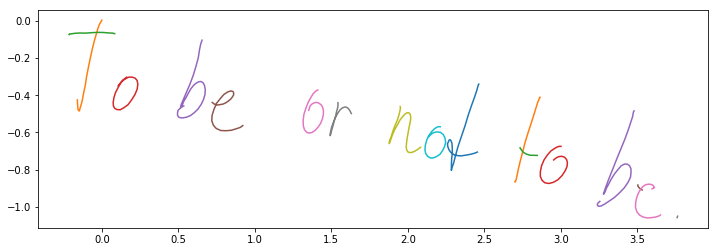

In [6]:
text = 'To be or not to be.'
path = 'models/model-29'

with tf.Session() as session:
    saver = tf.train.import_meta_graph(path + '.meta')
    saver.restore(session, path)
    phi_data, window_data, kappa_data, stroke_data, coords = get_handwriting(session, text, translation,bias = 1.)

def get_cumilative_sum(points):
    sums = np.cumsum(points[:, :2], axis=0)
    return np.concatenate([sums, points[:, 2:]], axis=1)
    
figure(num=None, figsize=(12, 4))
for stroke in split_strokes(get_cumilative_sum(np.array(coords))):
    plt.plot(stroke[:, 0], -stroke[:, 1])
plt.show()

### Conclusion

1. We are able to generate a handwritten text which is readable but does contain some errors in the co-ordinates.
2. The handwritting style is random every time we try to generate the handwritting this would be because the model selects the style at random. To get a specific style we may have to prime the model with some style before the actual output is generated. Which is not included in this scope.

## Licence

<div class="alert alert-block alert-info">
MIT License 

Copyright (c) 2019 Ninad Subhedar 

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions: 

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software. 

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</div>